In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-05-12 18:16:31.970649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747073792.215449      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747073792.286538      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing and Model Development with PSO Hyperparameter Optimization

In [2]:
# Import and preprocess data
# Using the same preprocessing steps as optimized_lstm.ipynb
df = pd.read_csv('/kaggle/input/dataset2/df_file.csv')

def clean(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

def remove_stopwrods(text):
    filtered = ' '.join(word for word in text.split() if word not in stop_words)
    return filtered

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def tokenize(text):
    return word_tokenize(text)

def stemmer(text):
    stemmer_instance = PorterStemmer()
    return [stemmer_instance.stem(word) for word in text]

def lemmatizer(text):
    return [WordNetLemmatizer().lemmatize(word) for word in text]

# Apply preprocessing steps
df['cleaned_text'] = df['Text'].apply(clean)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwrods)
df['tockenized'] = df['cleaned_text'].apply(lambda x: tokenize(x))
df['tockenized'] = df['tockenized'].apply(lambda x: lemmatizer(x))
df['tockenized'] = df['tockenized'].apply(lambda x: stemmer(x))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Tokenization and sequence preparation
from tensorflow import keras
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['tockenized'])
df['sequence'] = tokenizer.texts_to_sequences(df['tockenized'])

# Calculate input shape
input_shape = int(sum(df['sequence'].apply(lambda x:len(x)))/len(df['sequence']))

# Sequence Padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(df['sequence'], maxlen=197)

# Label encoding
from sklearn.preprocessing import LabelEncoder
LB = LabelEncoder()
y = LB.fit_transform(df['Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Calculate Max_words
Max_words = (max(map(max, X))) + 1

In [4]:
# PSO Hyperparameter Optimization
import random

def pso(n_particles=10, epochs=15, w=0.7, c1=2, c2=1.5, fitness_function=None):
    # Define dimension ranges for each hyperparameter
    dim_ranges = [
        (64, 512),    # lstm1_units
        (32, 256),    # lstm2_units
        (16, 64),     # dense_units
        (0.1, 0.5),   # dropout1
        (0.1, 0.5),   # dropout2
        (0.0001, 0.01) # learning_rate
    ]
    
    n_dimensions = len(dim_ranges)
    
    # Initialize particles
    positions = np.zeros((n_particles, n_dimensions))
    velocities = np.zeros((n_particles, n_dimensions))
    
    # Initialize each dimension within its range
    for i in range(n_dimensions):
        positions[:, i] = np.random.uniform(dim_ranges[i][0], dim_ranges[i][1], n_particles)
        velocities[:, i] = np.random.uniform(-1, 1, n_particles)
    
    # Personal best
    pbest = positions.copy()
    pbest_values = np.array([fitness_function(pos) for pos in pbest])
    
    # Global best
    gbest = pbest[np.argmax(pbest_values)]
    gbest_value = np.max(pbest_values)
    
    for epoch in range(epochs):
        for i in range(n_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            
            # Update velocity
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest[i] - positions[i])
                + c2 * r2 * (gbest - positions[i])
            )
            
            # Update position
            positions[i] += velocities[i]
            
            # Clip positions to valid ranges
            for j in range(n_dimensions):
                positions[i, j] = np.clip(positions[i, j], dim_ranges[j][0], dim_ranges[j][1])
            
            # Evaluate fitness
            fitness_value = fitness_function(positions[i])
            if fitness_value > pbest_values[i]:
                pbest[i] = positions[i]
                pbest_values[i] = fitness_value
        
        # Update global best
        if np.max(pbest_values) > gbest_value:
            gbest = pbest[np.argmax(pbest_values)]
            gbest_value = np.max(pbest_values)
        
        print(f"Epoch {epoch}: Best fitness = {gbest_value:.6f}")
    
    return gbest, gbest_value

In [5]:


# Define hyperparameter ranges as the search space
param_ranges = {
    'lstm1_units': (64, 512),
    'lstm2_units': (32, 256),
    'dense_units': (16, 64),
    'dropout1': (0.1, 0.5),
    'dropout2': (0.1, 0.5),
    'learning_rate': (0.0001, 0.01)
}

def create_model(params):
    model = Sequential([
        Embedding(Max_words + 1, 100, input_length=input_shape),
        LSTM(int(params['lstm1_units']), return_sequences=True),
        Dropout(params['dropout1']),
        LSTM(int(params['lstm2_units'])),
        Dropout(params['dropout2']),
        Dense(int(params['dense_units']), activation='selu'),
        Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# PSO fitness function
def fitness_function(particle):
    params = {
        'lstm1_units': particle[0],
        'lstm2_units': particle[1],
        'dense_units': particle[2],
        'dropout1': particle[3],
        'dropout2': particle[4],
        'learning_rate': particle[5]
    }
    
    model = create_model(params)
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    return history.history['val_accuracy'][-1]

# Run PSO optimization
best_position, best_fitness = pso(
    n_particles=10,
    epochs=15,
    fitness_function=fitness_function
)

print(f"Best parameters found: {best_position}")
print(f"Best fitness achieved: {best_fitness}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1747073820.568620      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1747073826.643275      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 0: Best fitness = 0.941011
Epoch 1: Best fitness = 0.941011
Epoch 2: Best fitness = 0.941011
Epoch 3: Best fitness = 0.941011
Epoch 4: Best fitness = 0.941011
Epoch 5: Best fitness = 0.941011
Epoch 6: Best fitness = 0.941011
Epoch 7: Best fitness = 0.941011
Epoch 8: Best fitness = 0.946629
Epoch 9: Best fitness = 0.946629
Epoch 10: Best fitness = 0.949438
Epoch 11: Best fitness = 0.949438
Epoch 12: Best fitness = 0.949438
Epoch 13: Best fitness = 0.949438
Epoch 14: Best fitness = 0.949438
Best parameters found: [6.40000000e+01 4.76850368e+01 2.34345623e+01 5.00000000e-01
 5.00000000e-01 1.00569299e-03]
Best fitness achieved: 0.949438214302063


In [6]:
# Create and train final model with best parameters
final_params = {
    'lstm1_units': int(best_position[0]),
    'lstm2_units': int(best_position[1]),
    'dense_units': int(best_position[2]),
    'dropout1': best_position[3],
    'dropout2': best_position[4],
    'learning_rate': best_position[5]
}

final_model = create_model(final_params)

# Training callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint(
        filepath="model_checkpoints/pso_lstm_checkpoint.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

# Train final model
history = final_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=20,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2829 - loss: 1.5896
Epoch 1: val_accuracy improved from -inf to 0.64607, saving model to model_checkpoints/pso_lstm_checkpoint.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2860 - loss: 1.5875 - val_accuracy: 0.6461 - val_loss: 1.0373 - learning_rate: 0.0010
Epoch 2/25
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6891 - loss: 0.8471
Epoch 2: val_accuracy improved from 0.64607 to 0.92697, saving model to model_checkpoints/pso_lstm_checkpoint.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6925 - loss: 0.8409 - val_accuracy: 0.9270 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 3/25
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9482 - loss: 0.2329
Epoch 3: val_accuracy did not improve from 0.92697
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9479 - loss: 0.2331 - val_accuracy: 0.8315 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 4/25
70/72 ━━━━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9133 - loss: 0.4780

Test accuracy: 0.9169
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        84
           1       0.97      0.96      0.96       100
           2       0.98      0.88      0.92        91
           3       0.89      0.91      0.90        64
           4       0.87      0.92      0.89       106

    accuracy                           0.92       445
   macro avg       0.92      0.92      0.92       445
weighted avg       0.92      0.92      0.92       445



<Figure size 1000x800 with 0 Axes>

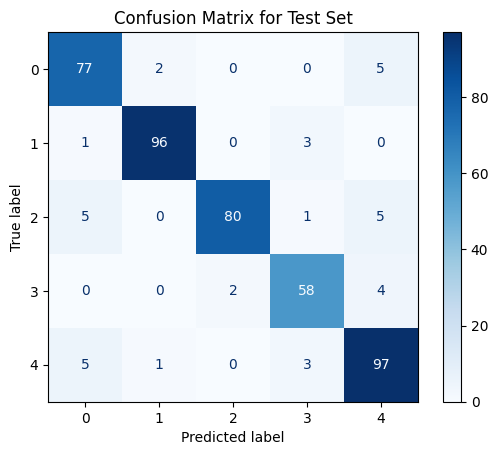

In [7]:
# Evaluate model performance
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_accuracy:.4f}")

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Save model and tokenizer
final_model.save('pso_lstm_model.h5')
import pickle
with open('pso_lstm_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
final_model.save('PSO_lstm_model.h5')  # Legacy HDF5 format

In [10]:
# Save tokenizer for later use
import pickle
with open('pso_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)